In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install mtcnn

✅ Mask classification model loaded successfully
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 2)
Expected input size: 224x224
Step 1: Testing model interpretation...

TESTING MODEL INTERPRETATION

--- 1801.jpg: No mask (businessman) ---
Model output shape: (1, 2)
Model output: [[0.45227122 0.5477287 ]]
Interpretation 1 - [mask, no_mask]: [0.452, 0.548]
Interpretation 2 - [no_mask, mask]: [0.452, 0.548]

--- 4591.png: Has mask (woman in orange) ---
Model output shape: (1, 2)
Model output: [[0.6368368  0.36316314]]
Interpretation 1 - [mask, no_mask]: [0.637, 0.363]
Interpretation 2 - [no_mask, mask]: [0.637, 0.363]

--- 2756.png: Has mask (children) ---
Model output shape: (1, 2)
Model output: [[0.65447575 0.34552422]]
Interpretation 1 - [mask, no_mask]: [0.654, 0.346]
Interpretation 2 - [no_mask, mask]: [0.654, 0.346]

Step 2: Determining correct interpretation...

FIXING MODEL INTERPRETATION

1801.jpg - Expected: No Mask
Raw prediction: [[0.45227122 0.5477287 ]]

45

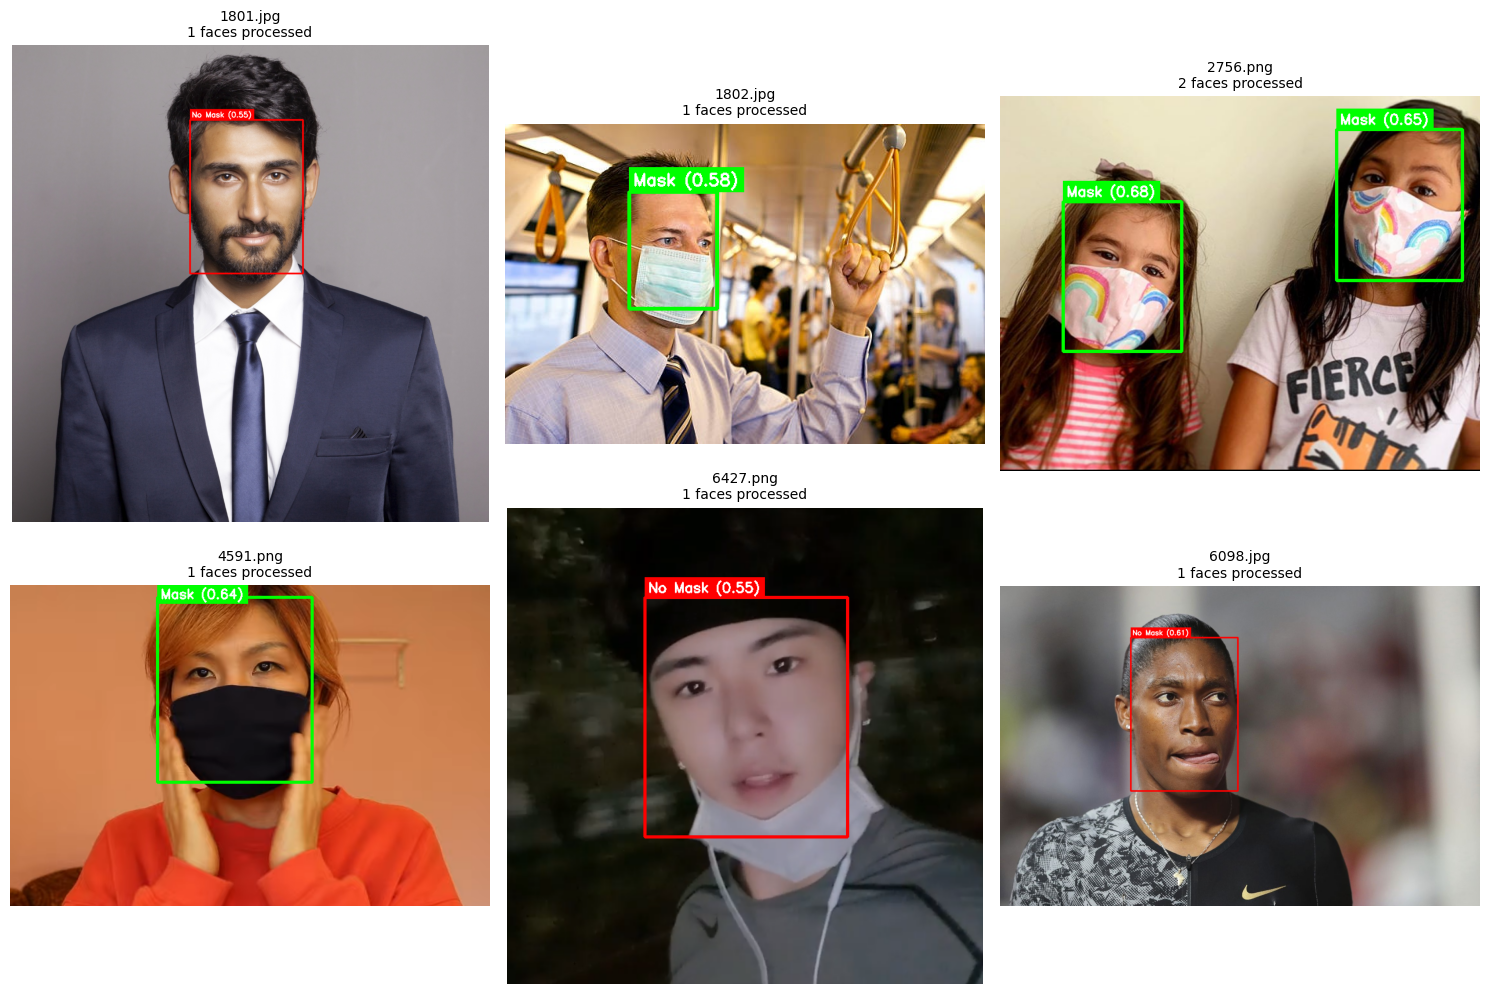


PROCESSING COMPLETED!

Step 4: Analyzing problematic images individually...

--- Analyzing: 1802.jpg ---
Trying MTCNN detection...
MTCNN found 1 faces
Total unique faces: 1


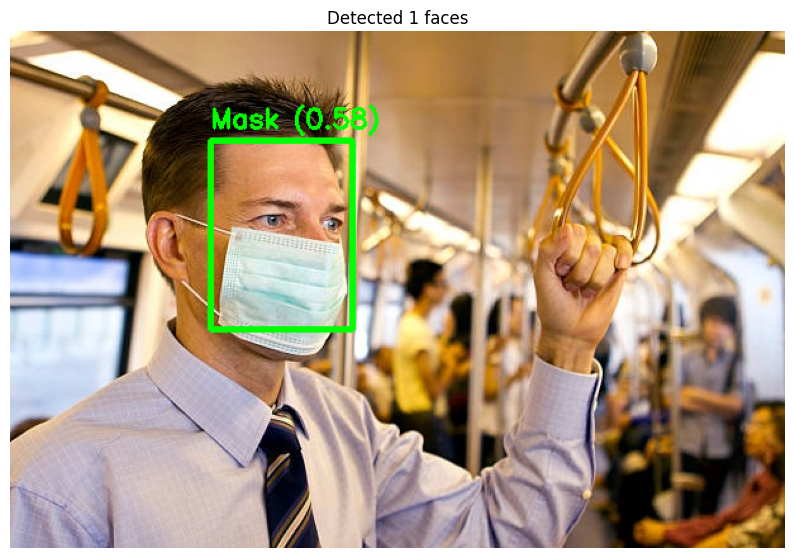


--- Analyzing: 4591.png ---
Trying MTCNN detection...
MTCNN found 1 faces
Total unique faces: 1


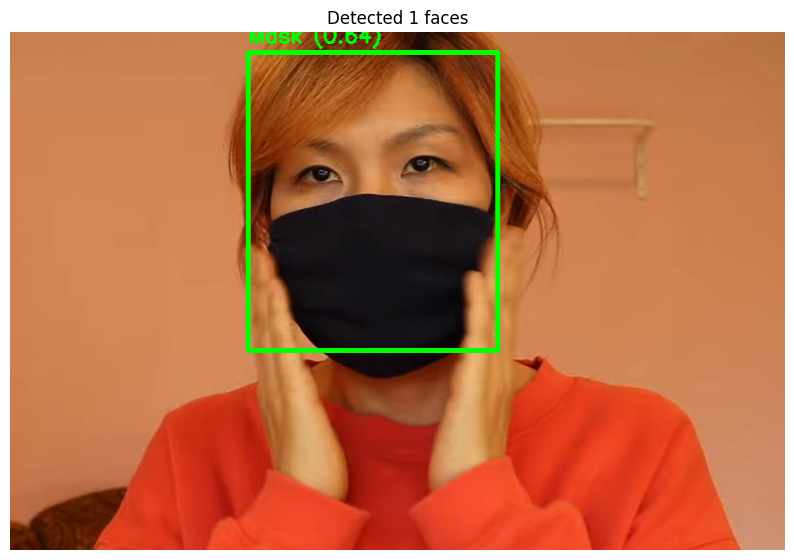

In [ ]:
### **Refactored Code (MTCNN Integration)**
from mtcnn import MTCNN  # <-- NEW
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array


# Your existing paths
image_directory = "/content/drive/My Drive/Colab Notebooks/medical-mask/images"
model_path = '/content/drive/My Drive/Colab Notebooks/medical-mask/model-facemask.h5'

# Global variable to store correct interpretation
CORRECT_INTERPRETATION = None

# Initialize MTCNN detector
mtcnn_detector = MTCNN()

# Load your mask classification model
try:
    model = load_model(model_path)
    print("✅ Mask classification model loaded successfully")
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")

    img_size = model.input_shape[1]
    print(f"Expected input size: {img_size}x{img_size}")

except Exception as e:
    print(f"❌ Error loading mask classification model: {e}")
    model = None
    img_size = 224

def adjust_gamma(image, gamma=1.0):
    if image is None:
        return None
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

def preprocess_face_for_model(face_region, target_size):
    try:
        face_resized = cv2.resize(face_region, (target_size, target_size))
        face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
        face_array = img_to_array(face_rgb)
        face_array = face_array.astype('float32') / 255.0
        face_array = np.expand_dims(face_array, axis=0)
        return face_array
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return None

def preprocess_image_for_detection(image):
    versions = []
    versions.append(image)
    bright = cv2.convertScaleAbs(image, alpha=1.2, beta=30)
    versions.append(bright)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    enhanced = cv2.merge([l, a, b])
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)
    versions.append(enhanced)
    return versions

# --- NEW: MTCNN face detection ---
def detect_faces_mtcnn(image, min_confidence=0.90):
    faces = []
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = mtcnn_detector.detect_faces(rgb_image)
    for res in results:
        x, y, w, h = res['box']
        conf = res['confidence']
        if conf >= min_confidence:
            x1, y1 = max(0, x), max(0, y)
            x2, y2 = min(image.shape[1], x + w), min(image.shape[0], y + h)
            faces.append((x1, y1, x2, y2, conf))
    return faces

def classify_mask(face_region):
    global CORRECT_INTERPRETATION
    if model is None:
        return classify_mask_simple(face_region)
    try:
        processed_face = preprocess_face_for_model(face_region, img_size)
        if processed_face is None:
            return 0.5, "Error"
        prediction = model.predict(processed_face, verbose=0)
        if CORRECT_INTERPRETATION:
            return classify_mask_fixed(face_region, CORRECT_INTERPRETATION)
        if len(prediction.shape) > 1 and prediction.shape[1] == 2:
            class0 = float(prediction[0][0])
            class1 = float(prediction[0][1])
            return class1, "Model"
        else:
            single_prob = float(prediction.flatten()[0])
            return single_prob, "Model"
    except Exception as e:
        print(f"Error in mask classification: {e}")
        return 0.5, "Error"

def classify_mask_simple(face_region):
    try:
        hsv = cv2.cvtColor(face_region, cv2.COLOR_BGR2HSV)
        h, w = face_region.shape[:2]
        lower_face = hsv[h//2:, :]
        lower_medical_blue = np.array([100, 100, 50])
        upper_medical_blue = np.array([130, 255, 255])
        lower_surgical = np.array([0, 0, 180])
        upper_surgical = np.array([180, 50, 255])
        lower_dark = np.array([0, 0, 0])
        upper_dark = np.array([180, 255, 80])
        mask_medical = cv2.inRange(lower_face, lower_medical_blue, upper_medical_blue)
        mask_surgical = cv2.inRange(lower_face, lower_surgical, upper_surgical)
        mask_dark = cv2.inRange(lower_face, lower_dark, upper_dark)
        combined_mask = cv2.bitwise_or(mask_medical, mask_surgical)
        combined_mask = cv2.bitwise_or(combined_mask, mask_dark)
        total_pixels = lower_face.shape[0] * lower_face.shape[1]
        mask_pixels = cv2.countNonZero(combined_mask)
        mask_ratio = mask_pixels / total_pixels
        if mask_ratio > 0.15:
            confidence = min(mask_ratio * 3, 0.95)
        else:
            confidence = mask_ratio * 2
        return confidence, "Simple"
    except Exception as e:
        print(f"Error in simple classification: {e}")
        return 0.5, "Error"

def test_model_interpretation():
    print("\n" + "="*60)
    print("TESTING MODEL INTERPRETATION")
    print("="*60)
    if model is None:
        print("❌ No model loaded")
        return
    test_images_info = {
        '1801.jpg': 'No mask (businessman)',
        '4591.png': 'Has mask (woman in orange)',
        '2756.png': 'Has mask (children)'
    }
    for img_name, description in test_images_info.items():
        img_path = os.path.join(image_directory, img_name)
        if not os.path.exists(img_path):
            continue
        print(f"\n--- {img_name}: {description} ---")
        image = cv2.imread(img_path)
        if image is None:
            continue
        image_versions = preprocess_image_for_detection(image)
        faces = []
        for img_version in image_versions:
            faces.extend(detect_faces_mtcnn(img_version, min_confidence=0.90))
            if faces:
                break
        if faces:
            startX, startY, endX, endY, conf = faces[0]
            face_region = image[startY:endY, startX:endX]
            if face_region.size > 0:
                processed_face = preprocess_face_for_model(face_region, img_size)
                if processed_face is not None:
                    prediction = model.predict(processed_face, verbose=0)
                    print(f"Model output shape: {prediction.shape}")
                    print(f"Model output: {prediction}")
                    if len(prediction.shape) > 1 and prediction.shape[1] == 2:
                        print(f"Interpretation 1 - [mask, no_mask]: [{prediction[0][0]:.3f}, {prediction[0][1]:.3f}]")
                        print(f"Interpretation 2 - [no_mask, mask]: [{prediction[0][0]:.3f}, {prediction[0][1]:.3f}]")

def detect_and_classify_masks():
    print("\n" + "="*60)
    print("ENHANCED FACE MASK DETECTION")
    print("="*60)
    test_images = ['1801.jpg', '1802.jpg', '2756.png', '4591.png', '6427.png', '6098.jpg']
    existing_images = []
    for img in test_images:
        img_path = os.path.join(image_directory, img)
        if os.path.exists(img_path):
            existing_images.append(img)
    if not existing_images:
        available_images = [f for f in os.listdir(image_directory)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        existing_images = available_images[:6] if available_images else []
    if not existing_images:
        print("❌ No images found in directory!")
        return
    print(f"Processing {len(existing_images)} images...")
    fig = plt.figure(figsize=(15, 10))
    rows = 2
    cols = 3
    colors = {'Mask': (0, 255, 0), 'No Mask': (0, 0, 255)}
    for j, img_name in enumerate(existing_images[:6]):
        print(f"\n--- Processing {j+1}: {img_name} ---")
        img_path = os.path.join(image_directory, img_name)
        image = cv2.imread(img_path)
        if image is None:
            print(f"❌ Failed to load: {img_name}")
            continue
        original_image = image.copy()
        image_versions = preprocess_image_for_detection(image)
        all_faces = []
        for idx, img_version in enumerate(image_versions):
            faces_mtcnn = detect_faces_mtcnn(img_version, min_confidence=0.90)
            all_faces.extend(faces_mtcnn)
        # Remove duplicates
        unique_faces = []
        for face in all_faces:
            is_duplicate = False
            for existing in unique_faces:
                if (abs(existing[0] - face[0]) < 30 and abs(existing[1] - face[1]) < 30):
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_faces.append(face)
        faces = unique_faces
        if not faces:
            print("  No faces detected after all attempts")
            if j < 6:
                ax = fig.add_subplot(rows, cols, j + 1)
                ax.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                ax.set_title(f"{img_name}\nNo faces detected", fontsize=10)
                ax.axis('off')
            continue
        print(f"  Found {len(faces)} faces")
        display_image = original_image.copy()
        for i, (startX, startY, endX, endY, conf) in enumerate(faces):
            try:
                face_region = original_image[startY:endY, startX:endX]
                if face_region.size == 0:
                    continue
                mask_prob, classification_method = classify_mask(face_region)
                if mask_prob > 0.5:
                    label = "Mask"
                    confidence_score = mask_prob
                else:
                    label = "No Mask"
                    confidence_score = 1 - mask_prob
                color = colors[label]
                print(f"    Face {i+1}: {label} (confidence: {confidence_score:.3f}, method: {classification_method})")
                cv2.rectangle(display_image, (startX, startY), (endX, endY), color, 3)
                label_text = f"{label} ({confidence_score:.2f})"
                text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
                text_y = max(startY, text_size[1] + 15)
                cv2.rectangle(display_image, (startX, text_y - text_size[1] - 15),
                             (startX + text_size[0] + 10, text_y), color, -1)
                cv2.putText(display_image, label_text, (startX + 5, text_y - 8),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            except Exception as e:
                print(f"    ❌ Error processing face {i+1}: {e}")
                continue
        if j < 6:
            ax = fig.add_subplot(rows, cols, j + 1)
            ax.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
            ax.set_title(f"{img_name}\n{len(faces)} faces processed", fontsize=10)
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n" + "="*60)
    print("PROCESSING COMPLETED!")
    print("="*60)

def analyze_single_image(image_path):
    print(f"\n--- Analyzing: {os.path.basename(image_path)} ---")
    image = cv2.imread(image_path)
    if image is None:
        print("❌ Failed to load image")
        return
    print("Trying MTCNN detection...")
    faces_mtcnn = detect_faces_mtcnn(image, min_confidence=0.90)
    print(f"MTCNN found {len(faces_mtcnn)} faces")
    all_faces = faces_mtcnn
    unique_faces = []
    for face in all_faces:
        is_duplicate = False
        for existing in unique_faces:
            if (abs(existing[0] - face[0]) < 30 and abs(existing[1] - face[1]) < 30):
                is_duplicate = True
                break
        if not is_duplicate:
            unique_faces.append(face)
    print(f"Total unique faces: {len(unique_faces)}")
    display_image = image.copy()
    colors = {'Mask': (0, 255, 0), 'No Mask': (0, 0, 255)}
    for i, (startX, startY, endX, endY, conf) in enumerate(unique_faces):
        face_region = image[startY:endY, startX:endX]
        if face_region.size == 0:
            continue
        mask_prob, method = classify_mask(face_region)
        if mask_prob > 0.5:
            label = "Mask"
            confidence_score = mask_prob
        else:
            label = "No Mask"
            confidence_score = 1 - mask_prob
        color = colors[label]
        cv2.rectangle(display_image, (startX, startY), (endX, endY), color, 3)
        label_text = f"{label} ({confidence_score:.2f})"
        cv2.putText(display_image, label_text, (startX, startY - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected {len(unique_faces)} faces")
    plt.axis('off')
    plt.show()

def fix_model_interpretation():
    global CORRECT_INTERPRETATION
    print("\n" + "="*60)
    print("FIXING MODEL INTERPRETATION")
    print("="*60)
    if model is None:
        print("❌ No model loaded")
        return None
    test_cases = {
        '1801.jpg': False,
        '4591.png': True,
        '2756.png': True
    }
    interpretation_scores = {
        "class0_is_mask": 0,
        "class1_is_mask": 0,
        "high_is_mask": 0,
        "high_is_no_mask": 0
    }
    for img_name, has_mask in test_cases.items():
        img_path = os.path.join(image_directory, img_name)
        if not os.path.exists(img_path):
            continue
        image = cv2.imread(img_path)
        if image is None:
            continue
        faces = detect_faces_mtcnn(image, min_confidence=0.90)
        if faces:
            startX, startY, endX, endY, conf = faces[0]
            face_region = image[startY:endY, startX:endX]
            if face_region.size > 0:
                processed_face = preprocess_face_for_model(face_region, img_size)
                if processed_face is not None:
                    prediction = model.predict(processed_face, verbose=0)
                    print(f"\n{img_name} - Expected: {'Mask' if has_mask else 'No Mask'}")
                    print(f"Raw prediction: {prediction}")
                    if len(prediction.shape) > 1 and prediction.shape[1] == 2:
                        class0 = float(prediction[0][0])
                        class1 = float(prediction[0][1])
                        if has_mask:
                            if class0 > class1:
                                interpretation_scores["class0_is_mask"] += 1
                            else:
                                interpretation_scores["class1_is_mask"] += 1
                        else:
                            if class0 > class1:
                                interpretation_scores["class1_is_mask"] += 1
                            else:
                                interpretation_scores["class0_is_mask"] += 1
                    else:
                        single_prob = float(prediction.flatten()[0])
                        if (has_mask and single_prob > 0.5) or (not has_mask and single_prob < 0.5):
                            interpretation_scores["high_is_mask"] += 1
                        else:
                            interpretation_scores["high_is_no_mask"] += 1
    best_interpretation = max(interpretation_scores, key=interpretation_scores.get)
    if interpretation_scores[best_interpretation] > 0:
        CORRECT_INTERPRETATION = best_interpretation
        print(f"\n✅ Best interpretation: {best_interpretation}")
        return best_interpretation
    return None

def classify_mask_fixed(face_region, interpretation):
    if model is None:
        return classify_mask_simple(face_region)
    try:
        processed_face = preprocess_face_for_model(face_region, img_size)
        if processed_face is None:
            return 0.5, "Error"
        prediction = model.predict(processed_face, verbose=0)
        if len(prediction.shape) > 1 and prediction.shape[1] == 2:
            class0 = float(prediction[0][0])
            class1 = float(prediction[0][1])
            if interpretation == "class0_is_mask":
                return class0, "Model"
            elif interpretation == "class1_is_mask":
                return class1, "Model"
            else:
                return class1, "Model"
        else:
            single_prob = float(prediction.flatten()[0])
            if interpretation == "high_is_mask":
                return single_prob, "Model"
            elif interpretation == "high_is_no_mask":
                return (1 - single_prob), "Model"
            else:
                return single_prob, "Model"
    except Exception as e:
        print(f"Error in mask classification: {e}")
        return 0.5, "Error"

if __name__ == "__main__":
    print("Step 1: Testing model interpretation...")
    test_model_interpretation()
    print("\nStep 2: Determining correct interpretation...")
    correct_interpretation = fix_model_interpretation()
    if correct_interpretation:
        print(f"\n✅ Using interpretation: {correct_interpretation}")
        def classify_mask(face_region):
            return classify_mask_fixed(face_region, correct_interpretation)
    print("\nStep 3: Running main detection with fixed interpretation...")
    detect_and_classify_masks()
    print("\nStep 4: Analyzing problematic images individually...")
    problematic_images = ['1802.jpg', '4591.png']
    for img_name in problematic_images:
        img_path = os.path.join(image_directory, img_name)
        if os.path.exists(img_path):
            analyze_single_image(img_path)